In [1]:
%matplotlib inline
import os
import glob
import pylab
import pandas as pd
import pydicom
import numpy as np

## following directions and using code from:
[exploratory data analysis](https://www.kaggle.com/peterchang77/exploratory-data-analysis) <br>

In [11]:
!ls ../data/all

GCP Credits Request Link - RSNA.txt stage_1_test_images.zip
stage_1_detailed_class_info.csv     stage_1_train_images
stage_1_sample_submission.csv       stage_1_train_images.zip
stage_1_test_images                 stage_1_train_labels.csv


In [3]:
df = pd.read_csv('../data/all/stage_1_train_labels.csv')
print(df.shape)
df.head()

(28989, 6)


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [20]:
patientId = df['patientId'][0]
dcm_file = '../data/all/stage_1_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)
# print(dcm_data)

In [23]:
os.path.isdir('../data/all')
os.listdir('../data/all')

['stage_1_detailed_class_info.csv',
 'stage_1_train_images.zip',
 'stage_1_test_images.zip',
 'stage_1_train_labels.csv',
 'stage_1_test_images',
 'GCP Credits Request Link - RSNA.txt',
 'stage_1_train_images',
 'stage_1_sample_submission.csv']

In [34]:
from PIL import Image
train_dir = '../data/all/stage_1_train_images'
test_dir = '../data/all/stage_1_test_images'
dest_dir = os.getcwd()
print('destination directory:', dest_dir)
test_files_list = os.listdir(test_dir)
print('patientID', test_files_list[0].split('.')[0])

destination directory: /Users/mojo/git_clone/dlanier/kaggle_challenge_01/kagglePneumoniaDetective
patientID 1caa4dac-4bac-419b-91d4-cac2d8408ccd


In [37]:
# get the image and re-write as .jpg
patientId = test_files_list[0].split('.')[0]
dcm_file = os.path.join(test_dir, '%s.dcm' % patientId)
dcm_data = pydicom.read_file(dcm_file)

im = dcm_data.pixel_array
pil_im = Image.fromarray(im)
# print(type(im))
# print(im.dtype)
# print(im.shape)
# display(pil_im)
# pylab.imshow(im, cmap=pylab.cm.gist_gray)
# pylab.axis('off')
im_full_file_name = os.path.join(dest_dir, '%s'%patientId + '.jpg')
pil_im.save(im_full_file_name)
print(im_full_file_name)

/Users/mojo/git_clone/dlanier/kaggle_challenge_01/kagglePneumoniaDetective/1caa4dac-4bac-419b-91d4-cac2d8408ccd.jpg


In [ ]:
def write_negative_test_images(patientID, parsedict, class_df, out_dir=None):
    """ written_files_list = write_negative_test_images(patientID, parsedict, class_df, out_dir=None) 
    Note that file name L and R is patient point of view whereas variable names are X-ray point of view
    """
    if out_dir is None: out_dir = os.getcwd()
        
    # arbitrary cropping boxes
    row_crop = np.array([0.2, 0.7])
    col_crop = np.array([0.23, 0.46, 0.54, 0.77])
    
    written_files_list = []
    class_code = get_class_code(patientID, class_df) + '_Negative'
    dcm_file_name = parsedict[patientID]['dicom']
    if os.path.isfile(dcm_file_name):
        dcm_data = pydicom.read_file(dcm_file_name)
        im = dcm_data.pixel_array
        im_size = im.shape
        row_bounds = np.int_(row_crop * im_size[0])
        col_bounds = np.int_(col_crop * im_size[1])

        left_im = im[row_bounds[0]:row_bounds[1], col_bounds[0]:col_bounds[1]]
        left_im = Image.fromarray(left_im)
        left_box_file_name = patientID + '_R_' + class_code + file_ext
        left_box_full_file_name = os.path.join(out_dir, left_box_file_name)
        left_im.save(left_box_full_file_name, 'png')
        written_files_list.append(left_box_file_name)

        right_im = im[row_bounds[0]:row_bounds[1], col_bounds[2]:col_bounds[3]]
        right_im = Image.fromarray(right_im)
        right_box_file_name = patientID + '_L_' + class_code + file_ext
        right_box_full_file_name = os.path.join(out_dir, right_box_file_name)
        right_im.save(right_box_full_file_name, 'png')
        written_files_list.append(right_box_file_name)
    
    return written_files_list

(-0.5, 1023.5, 1023.5, -0.5)

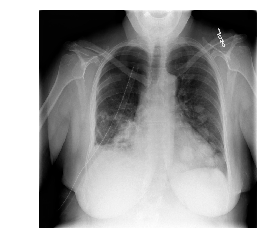

In [7]:
pylab.imshow(im, cmap=pylab.cm.gist_gray)
pylab.axis('off')

In [12]:
def parse_data(df):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }
    """
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': '../data/all/stage_1_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    pylab.imshow(im, cmap=pylab.cm.gist_gray)
    pylab.axis('off')

def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

{'boxes': [[152.0, 264.0, 379.0, 213.0], [152.0, 562.0, 453.0, 256.0]], 'dicom': '../data/all/stage_1_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm', 'label': 1}


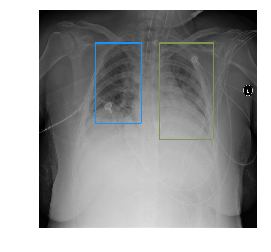

In [13]:
parsed = parse_data(df)
print(parsed['00436515-870c-4b36-a041-de91049b9ab4'])
draw(parsed['00436515-870c-4b36-a041-de91049b9ab4'])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
class                No Lung Opacity / Not Normal
Name: 0, dtype: object


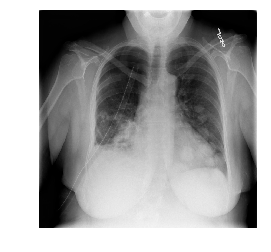

In [15]:
df_detailed = pd.read_csv('../data/all/stage_1_detailed_class_info.csv')
print(df_detailed.iloc[0])
patientId = df_detailed['patientId'][0]
draw(parsed[patientId])

In [16]:
summary = {}
for n, row in df_detailed.iterrows():
    if row['class'] not in summary:
        summary[row['class']] = 0
    summary[row['class']] += 1
    
print(summary)

{'Lung Opacity': 8964, 'Normal': 8525, 'No Lung Opacity / Not Normal': 11500}
